In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 16.7 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512545 sha256=8987ebcfcbbf840508369b07bb6836ba9c12a17f7824a5e5e0ff06bac7aea511
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d5

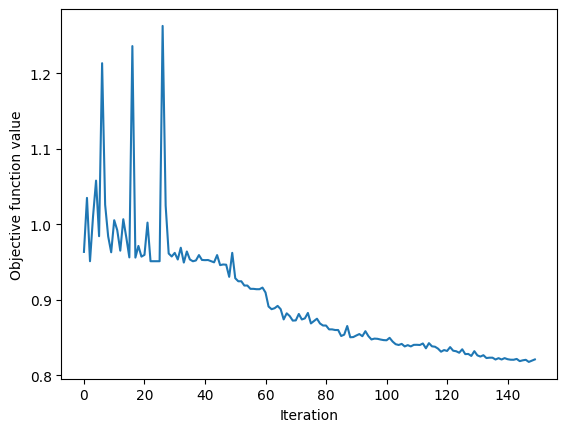

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88       352
         1.0       1.00      0.72      0.84       336

    accuracy                           0.86       688
   macro avg       0.89      0.86      0.86       688
weighted avg       0.89      0.86      0.86       688

[[352   0]
 [ 94 242]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86       140
         1.0       1.00      0.71      0.83       156

    accuracy                           0.85       296
   macro avg       0.88      0.86      0.85       296
weighted avg       0.88      0.85      0.85       296

[[140   0]
 [ 45 111]] = confusion matrix for test set 
 
0.86 = roc_auc_score for test set 



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

data = pd.read_csv('creditcard.csv')
histogram = data.hist(bins=20)


normal = data[data.Class==0]
fraud = data[data.Class==1]

num_normal = normal.shape[0]
num_fraud = fraud.shape[0]

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")

ratio = num_normal / num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')

normal_fraud_ratio = 1  # balance the dataset
normal_sample = normal.sample(normal_fraud_ratio * num_fraud)
sample = pd.concat([fraud, normal_sample], axis=0)


for i in range(100):
    sample = np.random.permutation(sample)

X, y = sample[:, :-1], sample[:, -1]

# Scale the features to [0,1]
X = MinMaxScaler().fit_transform(X)

num_examples, num_features = X.shape
print("number of examples = ", num_examples)
print("number of features = ", num_features)

# Zero padding to make number of features a power of 2
n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim - num_features))
X = np.append(X, zeros, axis=1)

num_examples, num_features = X.shape
print("number of examples = ", num_examples)
print("number of features = ", num_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

# Importing the updated qiskit components
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes

# Define feature map
fm = RawFeatureVector(feature_dimension=num_features)
fm.draw()

# Parametrized quantum circuit for classification
pqc = RealAmplitudes(num_qubits=n, reps=4)  # Increase reps for more parameters
pqc.decompose().draw()

# Define the optimizer and estimator
from qiskit_algorithms.optimizers import COBYLA  # Updated path for optimizers
from qiskit.primitives import Sampler  # Replacing Estimator with Sampler in VQC

optimizer = COBYLA(maxiter=150)
sampler = Sampler()  # Replacing the Estimator

# Callback function to plot objective function values during optimization
from IPython.display import clear_output

objective_func_vals = []
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Use VQC (Variational Quantum Classifier)
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback
)

# Training the VQC model
%time
vqc.fit(X_train, y_train)

# Predicti
y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)


print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")
print(round(roc_auc_score(y_test, y_test_pred), 2), "= roc_auc_score for test set \n")

In [ ]:
warnings.filterwarnings('ignore')

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train)                          # fit model

    y_train_pred = ML_model.predict(X_train)       # predict with the trained model
    y_test_pred = ML_model.predict(X_test)


    print(classification_report(y_train, y_train_pred))     # evaluate model performance
    print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n")
    print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")

    print(70*'=')


#----------------------------------------------------------------------------------

print(70*'=')
ML_model = linear_model.LogisticRegression()            # create model instance
train_test(ML_model)








                     LogisticRegression() 

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       352
         1.0       1.00      0.87      0.93       336

    accuracy                           0.94       688
   macro avg       0.95      0.94      0.94       688
weighted avg       0.94      0.94      0.94       688

[[352   0]
 [ 43 293]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       140
         1.0       0.99      0.86      0.92       156

    accuracy                           0.92       296
   macro avg       0.93      0.93      0.92       296
weighted avg       0.93      0.92      0.92       296

[[139   1]
 [ 22 134]] = confusion matrix for test set 

0.93 = roc_auc_score for test set 



Number of normal examples = 284315
Number of fraud examples = 492

Normal to fraud ratio in the whole data = 577.88
Number of examples =  984
Number of features =  30
Number of examples after padding =  984
Number of features after padding =  16
(688, 16) (296, 16)
Shape of quantum-encoded training data: (688, 65536)
Shape of quantum-encoded testing data: (296, 65536)
                     LogisticRegression() 

Training set performance:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       337
           1       0.84      0.90      0.87       351

    accuracy                           0.86       688
   macro avg       0.86      0.86      0.86       688
weighted avg       0.86      0.86      0.86       688

[[275  62]
 [ 35 316]] = confusion matrix for train set 

Test set performance:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       155
           1       0.51      0.55      0.53

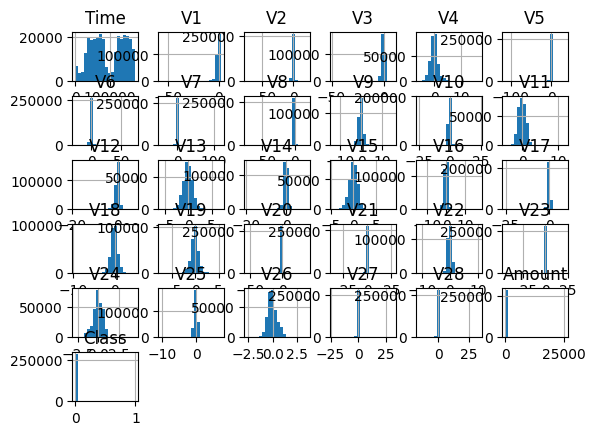

In [ ]:
 #Import necessary libraries for the hybrid model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import linear_model

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector

# Load the dataset and plot histograms
data = pd.read_csv('creditcard.csv')
histogram = data.hist(bins=20)

# Separate normal and fraud examples
normal = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

# Get the number of normal and fraud examples
num_normal = normal.shape[0]
num_fraud = fraud.shape[0]

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")

# Compute the ratio of normal to fraud examples
ratio = num_normal / num_fraud
print(f'Normal to fraud ratio in the whole data = {round(ratio, 2)}')

# Define the normal_fraud_ratio (for balancing the dataset)
normal_fraud_ratio = 1  # Adjust this ratio as needed to balance the dataset

# Balance the dataset by sampling normal transactions
normal_sample = normal.sample(n=normal_fraud_ratio * num_fraud, random_state=42)
sample = pd.concat([fraud, normal_sample], axis=0)

# Shuffle the dataset
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features (X) and labels (y)
X, y = sample.drop(columns=['Class']).values, sample['Class'].values

# Scale the features to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Get the number of examples and features
num_examples, num_features = X.shape
print("Number of examples = ", num_examples)
print("Number of features = ", num_features)

# Zero padding to make the number of features a power of 2
# Calculate the desired number of features (power of 2)
n = int(np.floor(np.log2(num_features)))  # Use floor to get the largest power of 2 less than num_features
dim = 2**n

# Select only the first 'dim' features
X = X[:, :16]

# Confirm the new shape of X after padding
num_examples, num_features = X.shape
print("Number of examples after padding = ", num_examples)
print("Number of features after padding = ", num_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

# Quantum Feature Map: ZZFeatureMap
fm = ZZFeatureMap(feature_dimension=num_features, reps=1)
fm.decompose().draw()

# Function to apply quantum feature map and return classical expectation values
def apply_quantum_feature_map(X):
    sampler = Sampler()  # Using the sampler to measure quantum states
    encoded_features = []

    for x in X:
        # Convert classical data into quantum states using the feature map
        quantum_circuit = fm.assign_parameters(x)
        # Generate the statevector (sampling the quantum state)
        state = Statevector.from_instruction(quantum_circuit)
        # Measure the state and calculate the expectation value for Pauli-Z
        encoded_features.append(np.real(state.data))  # Append the real part of the statevector as the feature

    return np.array(encoded_features)

# Apply quantum feature map to transform training and testing sets
X_train_quantum = apply_quantum_feature_map(X_train)
X_test_quantum = apply_quantum_feature_map(X_test)

print(f"Shape of quantum-encoded training data: {X_train_quantum.shape}")
print(f"Shape of quantum-encoded testing data: {X_test_quantum.shape}")

# Classical Logistic Regression Model
def train_test(ML_model):
    print(20*' ', ML_model, '\n')

    # Train the classical model using quantum-encoded data
    ML_model.fit(X_train_quantum, y_train)

    # Predictions for training and test sets
    y_train_pred = ML_model.predict(X_train_quantum)
    y_test_pred = ML_model.predict(X_test_quantum)

    # Evaluate model performance
    print("Training set performance:")
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

    print("Test set performance:")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n")
    print(round(roc_auc_score(y_test, y_test_pred), 2), "= roc_auc_score for test set \n")

    print(70*'=')

# Logistic Regression
ML_model = linear_model.LogisticRegression()
train_test(ML_model)

Number of normal examples = 284315
Number of fraud examples = 492

Normal to fraud ratio in the whole data = 577.88
Number of examples =  984
Number of features =  30
Number of examples after padding =  984
Number of features after padding =  16
(688, 16) (296, 16)
Shape of quantum-encoded training data: (688, 65536)
Shape of quantum-encoded testing data: (296, 65536)
                     LogisticRegression() 

Training set performance:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       337
           1       0.98      0.86      0.91       351

    accuracy                           0.92       688
   macro avg       0.92      0.92      0.92       688
weighted avg       0.93      0.92      0.92       688

[[331   6]
 [ 50 301]] = confusion matrix for train set 

Test set performance:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       155
           1       0.98      0.84      0.90

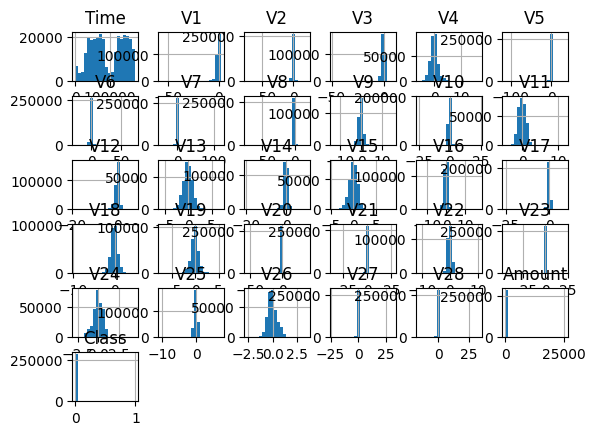

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import linear_model

from qiskit.circuit.library import ZFeatureMap  # Changed from ZZFeatureMap to ZFeatureMap
from qiskit.quantum_info import Statevector
from joblib import Parallel, delayed

# Load the dataset and plot histograms
data = pd.read_csv('creditcard.csv')
histogram = data.hist(bins=20)

# Separate normal and fraud examples
normal = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

# Get the number of normal and fraud examples
num_normal = normal.shape[0]
num_fraud = fraud.shape[0]

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")

# Compute the ratio of normal to fraud examples
ratio = num_normal / num_fraud
print(f'Normal to fraud ratio in the whole data = {round(ratio, 2)}')

# Define the normal_fraud_ratio (for balancing the dataset)
normal_fraud_ratio = 1  # Adjust this ratio as needed to balance the dataset

# Balance the dataset by sampling normal transactions
normal_sample = normal.sample(n=normal_fraud_ratio * num_fraud, random_state=42)
sample = pd.concat([fraud, normal_sample], axis=0)

# Shuffle the dataset
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features (X) and labels (y)
X, y = sample.drop(columns=['Class']).values, sample['Class'].values

# Scale the features to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Get the number of examples and features
num_examples, num_features = X.shape
print("Number of examples = ", num_examples)
print("Number of features = ", num_features)

# Zero padding to make the number of features a power of 2
'''n = int(np.ceil(np.log2(num_features)))  # Removed the -1
dim = 2**n
print(f'(Number of qubits, dimension of the Hilbert space) = {(n, dim)}')

# Add zero padding to make the feature size a power of 2
zeros = np.zeros((num_examples, dim - num_features))
X = np.hstack((X, zeros))
'''
n = int(np.floor(np.log2(num_features)))  # Use floor to get the largest power of 2 less than num_features
dim = 2**n

# Select only the first 'dim' features
X = X[:, :16]

# Confirm the new shape of X after padding
num_examples, num_features = X.shape
print("Number of examples after padding = ", num_examples)
print("Number of features after padding = ", num_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

# Quantum Feature Map: ZFeatureMap (Changed from ZZFeatureMap to ZFeatureMap)
fm = ZFeatureMap(feature_dimension=num_features, reps=1)  # Reduced reps for faster execution
fm.decompose().draw()

# Function to apply quantum feature map to a batch of data
def process_batch(batch):
    encoded_features = []
    for x in batch:
        quantum_circuit = fm.assign_parameters(x)
        state = Statevector.from_instruction(quantum_circuit)
        encoded_features.append(np.real(state.data))  # Use real part of the statevector as feature
    return encoded_features

# Function to apply quantum feature map in batches
def apply_quantum_feature_map_in_batches(X, batch_size=100):
    n_batches = len(X) // batch_size + (1 if len(X) % batch_size != 0 else 0)
    encoded_data = []

    for i in range(n_batches):
        batch = X[i*batch_size:(i+1)*batch_size]
        batch_encoded = process_batch(batch)
        encoded_data.extend(batch_encoded)

    return np.array(encoded_data)

# Function to parallelize quantum feature mapping
def apply_quantum_feature_map_parallel(X, n_jobs=-1):
    # -1 will use all available cores; you can limit this based on resources
    return np.array(Parallel(n_jobs=n_jobs)(delayed(process_batch)([x]) for x in X))

# Applying quantum feature map to training and testing data in batches
batch_size = 100  # Adjust this batch size as per your memory constraints
X_train_quantum = apply_quantum_feature_map_in_batches(X_train, batch_size=batch_size)
X_test_quantum = apply_quantum_feature_map_in_batches(X_test, batch_size=batch_size)

# Alternative: Apply quantum feature map in parallel (choose either batch processing or parallel)
# X_train_quantum = apply_quantum_feature_map_parallel(X_train)
# X_test_quantum = apply_quantum_feature_map_parallel(X_test)

print(f"Shape of quantum-encoded training data: {X_train_quantum.shape}")
print(f"Shape of quantum-encoded testing data: {X_test_quantum.shape}")

# Classical Logistic Regression Model
def train_test(ML_model):
    print(20*' ', ML_model, '\n')

    # Train the classical model using quantum-encoded data
    ML_model.fit(X_train_quantum, y_train)

    # Predictions for training and test sets
    y_train_pred = ML_model.predict(X_train_quantum)
    y_test_pred = ML_model.predict(X_test_quantum)

    # Evaluate model performance
    print("Training set performance:")
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

    print("Test set performance:")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n")
    print(round(roc_auc_score(y_test, y_test_pred), 2), "= roc_auc_score for test set \n")

    print(70*'=')

# Logistic Regression
ML_model = linear_model.LogisticRegression()
train_test(ML_model)


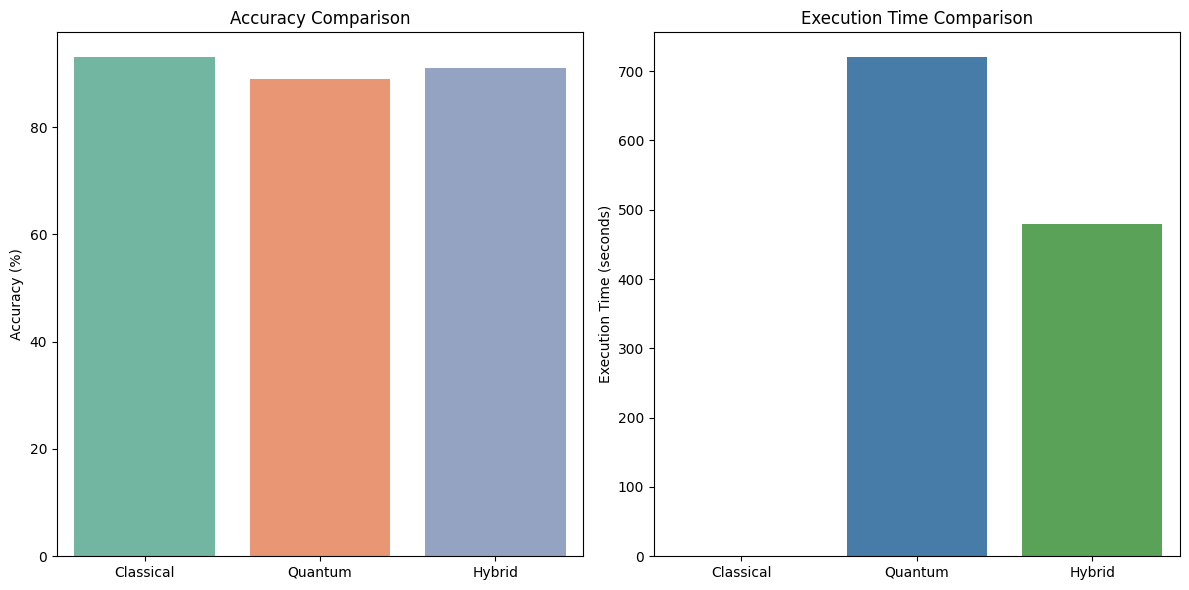

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for each model
models = ['Classical', 'Quantum', 'Hybrid']
accuracy = [93, 89, 91]  # Example accuracies in percentages
execution_time = [1, 720, 480]  # Example execution times in seconds

# Plotting the performance comparison

# Set up the figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for Accuracy
sns.barplot(x=models, y=accuracy, ax=ax[0], palette="Set2")
ax[0].set_title('Accuracy Comparison')
ax[0].set_ylabel('Accuracy (%)')

# Bar plot for Execution Time
sns.barplot(x=models, y=execution_time, ax=ax[1], palette="Set1")
ax[1].set_title('Execution Time Comparison')
ax[1].set_ylabel('Execution Time (seconds)')

# Show the plots
plt.tight_layout()
plt.show()
